## Agentic RAG with Langchain v1, Ollama, and FAISS
**Key Features:**
- Agent-based architecture with autonomous tool usage for document retrieval
- FAISS vector store for efficient semantic search across document embeddings
- Ollama integration with Qwen3 LLM and nomic-embed-text embeddings for local deployment
- Custom retrieval tool that finds and formats relevant document chunks with metadata
- Interactive chat interface with streaming responses and tool call visibility

In [1]:
# ollama pull nomic-embed-text
# ollama pull qwen3

In [2]:
# use the langchain pre-release for latest features
# pip install -U langchain langchain-ollama, langchain-community langchain-core faiss-cpu
import os
import warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv


load_dotenv()

# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with Qwen3
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434"
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# FAISS Vector Store (assumes data already exists from previous code)
db_name = "./../09. Vector Stores and Retrievals/health_supplements"
vector_store = FAISS.load_local(
    db_name,
    embeddings,
    allow_dangerous_deserialization=True
)

In [3]:
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T14:59:59.673727Z', 'done': True, 'done_reason': 'stop', 'total_duration': 751651300, 'load_duration': 66993700, 'prompt_eval_count': 11, 'prompt_eval_duration': 20360300, 'eval_count': 117, 'eval_duration': 638897500, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--d0632dfa-be91-49bd-a6c0-a181b5be089e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 117, 'total_tokens': 128})

In [4]:
# ============================================================================
# VECTOR STORE VERIFICATION
# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
doc_count = vector_store.index.ntotal
print(f"✓ Vector store found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "creatine"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Page {doc.metadata.get('page', '?')}: {doc.page_content[:100]}...")




🔍 Testing Vector Store Connection...
✓ Vector store found with 311 documents

✓ Sample search for 'creatine':
  1. Page 0: acids than traditional protein sources. Its numerous benefits have made it a popular choice
for snac...
  2. Page 1: Foods 2024, 13, 1424
2 of 21
and sports industry, evidence suggests that creatine can benefit not on...
  3. Page 10: supplements such as creatine or beta-alanine were used only once a week, which cannot be eﬀective [9...


In [5]:
results

[Document(id='fd6ca7af-09ea-44bf-b197-655128273c30', metadata={'producer': 'iLovePDF', 'creator': '', 'creationdate': '', 'source': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-10-21T11:38:50+00:00', 'trapped': '', 'modDate': 'D:20241021113850Z', 'creationDate': '', 'page': 0}, page_content='acids than traditional protein sources. Its numerous benefits have made it a popular choice\nfor snacks and drinks among consumers [3]. Another widely embraced supplement is\ncaffeine, which is found in many sports and food supplements. Caffeine reduces perceived\neffort, minimizes fatigue and pain, and proves to be effective for endurance and high-\nintensity activities, which is the choice of consumers [4].\nCreatine monohydrate is another well-known supplement 

In [6]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool()
def retrieve_context(query: str):
    """Retrieve relevant information for health related queries from the document to answer the query.
    
    """
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content, docs

# ============================================================================
# AGENT CREATION
# ============================================================================
tools = [retrieve_context]

# Agent prompt - simplified for single tool
system_prompt = """You are a research assistant with a document retrieval tool.

                    Tool:
                    - retrieve_context: Search the document for relevant information

                    Always use the tool to find relevant information before answering.
                    Cite page numbers and be thorough."""



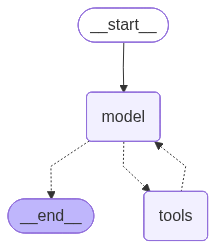

In [7]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, system_prompt=system_prompt)

rag_agent


In [8]:
rag_agent

response = rag_agent.invoke({'messages': "What is the use of BCAA?"})
response

🔍 Searching: 'What is the use of BCAA?'
✓ Found 4 relevant chunks


{'messages': [HumanMessage(content='What is the use of BCAA?', additional_kwargs={}, response_metadata={}, id='303d0e18-ccf5-4f1e-9f46-0bcec61fb5b5'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T15:00:01.9215556Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1484000300, 'load_duration': 66816200, 'prompt_eval_count': 199, 'prompt_eval_duration': 26715900, 'eval_count': 258, 'eval_duration': 1342656200, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--3ed7f0e8-f935-4392-964f-56f0dc07bc52-0', tool_calls=[{'name': 'retrieve_context', 'args': {'query': 'What is the use of BCAA?'}, 'id': 'fef18491-88ac-4963-be01-debfc57f8e32', 'type': 'tool_call'}], usage_metadata={'input_tokens': 199, 'output_tokens': 258, 'total_tokens': 457}),
  ToolMessage(content="('Page 1: Foods 2024, 13, 1424\\n2 of 21\\nand sports industry, evidence suggests that creatine can benefit not only athletes but also\\nthe elderly an

In [9]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [10]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
ask("how to gain muscle mass?")



Question: how to gain muscle mass?

💬 Answer:
how to gain muscle mass?

🔧 Using: retrieve_context with {'query': 'how to gain muscle mass'}
🔍 Searching: 'how to gain muscle mass'
✓ Found 4 relevant chunks

💬 Answer:
('Page 8: and strength gain among men. We detected more prevalent protein and creatine supplementation\namong younger compared to older ﬁtness center users, whereas the opposite was found for vitamin\nsupplementation. Other authors made similar observations [23] and it might reﬂect the diﬀerent\ntraining goals among age groups, i.e., more focus on strength and muscles among the younger and\nmore focus on health among the older age groups.\nComparable to other studies [4], we detected a positive correlation between training frequency\nand supplement usage. Nevertheless, the correlation is weak and is deﬁnitely not a predictor at the\nindividual level. The subject with the highest supplement intake of 100 weekly servings was training\nonly once a week.\n\nPage 5: for two tra

In [11]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit, q or exit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit' to exit
